In [105]:
import os
import re

import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

### Paths

In [106]:
NOTEBOOK_FILE_NAME = 'Data Analysis.ipynb'
IMAGES_PATH = 'data/images'
MASKED_IMAGES_PATH = 'data/masked_images'

ROOT_DIR = os.path.dirname(os.path.abspath(NOTEBOOK_FILE_NAME))
ROOT_DIR = os.path.split(ROOT_DIR)[0]

IMAGES_DIR = os.path.join(ROOT_DIR, IMAGES_PATH)
MASKED_IMAGES_DIR = os.path.join(ROOT_DIR, MASKED_IMAGES_PATH)

### Create Pandas Dataset

In [107]:
def map_diagnose(image_path: str) -> int:
    image_array = np.array(Image.open(os.path.join(MASKED_IMAGES_DIR, image_path)).convert('L'))

    if image_array.max() > 0:
        return 'Positive'
    return 'Negative'


images_list = os.listdir(IMAGES_DIR)
masks_list = os.listdir(MASKED_IMAGES_DIR)

images_list.sort(key=lambda _ : int(re.sub('\D', '', _)))
masks_list.sort(key=lambda _ : int(re.sub('\D', '', _)))

medical_df = pd.DataFrame({'image_path': images_list, 'masked_image_path': masks_list})
medical_df['tumor'] = medical_df.masked_image_path.map(map_diagnose)

### Data Distribution

In [108]:
TRAINING_SIZE = 0.7
VALIDATION_SIZE = 0.5

train_df, remaining = train_test_split(medical_df,
                                       train_size=TRAINING_SIZE,
                                       stratify=medical_df.tumor)

val_df, test_df = train_test_split(remaining,
                                   test_size=VALIDATION_SIZE,
                                   stratify=remaining.tumor)

In [109]:
px.histogram(data_frame=medical_df,
             x='tumor',
             color='tumor',
             width=1200)

In [110]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=train_df.tumor, name='Training'))
fig.add_trace(go.Histogram(x=val_df.tumor, name='Validation'))
fig.add_trace(go.Histogram(x=test_df.tumor, name='Test'))

fig.update_layout(barmode='stack', width=1200)

### Data Transformation

In [111]:
class BrainMRIDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 images_path: str,
                 masked_images_path: str,
                 transform: transforms.Compose=None) -> None:
        
        self.images_path = images_path
        self.masked_images_path = masked_images_path
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        image = self.dataframe.iloc[index].image_path
        mask = self.dataframe.iloc[index].masked_image_path

        image_array = np.array(Image.open(os.path.join(self.images_path, image)).convert('RGB'))
        mask_array = np.array(Image.open(os.path.join(self.masked_images_path, mask)).convert('L'))

        if self.transform is not None:
            image_array = self.transform(image_array)
            mask_array = self.transform(mask_array)
                
        return (image_array, mask_array)

In [112]:
train_transform_pipeline = transforms.Compose([transforms.ToTensor(),
                                               transforms.Resize((256, 256), antialias=True),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(degrees=90),
                                               transforms.RandomAffine(degrees=15)])

# train_transform_pipeline = transforms.Compose([transforms.ToTensor(),
#                                                transforms.Resize((256, 256), antialias=True)])

val_test_transform_pipeline = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((256, 256), antialias=True)])

In [113]:
train_dataset = BrainMRIDataset(train_df,
                                IMAGES_DIR,
                                MASKED_IMAGES_DIR,
                                train_transform_pipeline)

val_dataset = BrainMRIDataset(val_df,
                              IMAGES_DIR,
                              MASKED_IMAGES_DIR,
                              val_test_transform_pipeline)

test_dataset = BrainMRIDataset(test_df,
                               IMAGES_DIR,
                               MASKED_IMAGES_DIR,
                               val_test_transform_pipeline)

### Training Dataset Images

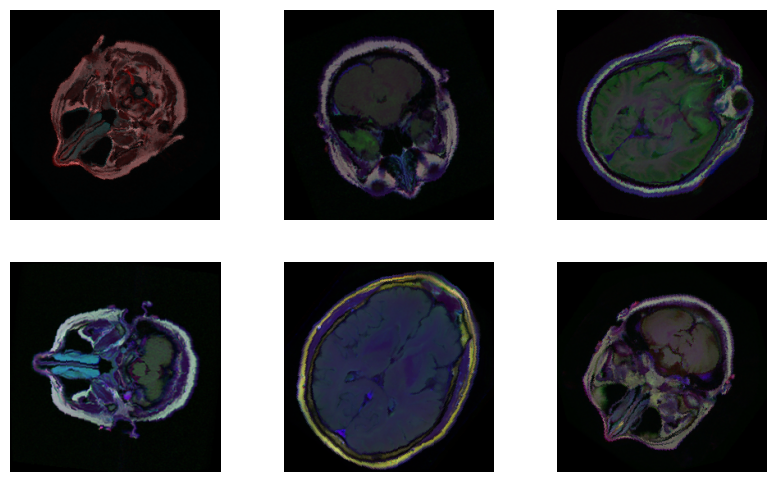

In [122]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(2):
    for j in range(3):
        example = train_dataset[random.randint(0, len(train_dataset))][0]
        example = example.permute(1, 2, 0)
        example = example.numpy() * 255
        example = example.astype(np.uint8)

        ax[i, j].imshow(example)
        ax[i, j].axis('off')

### Validation Dataset Images

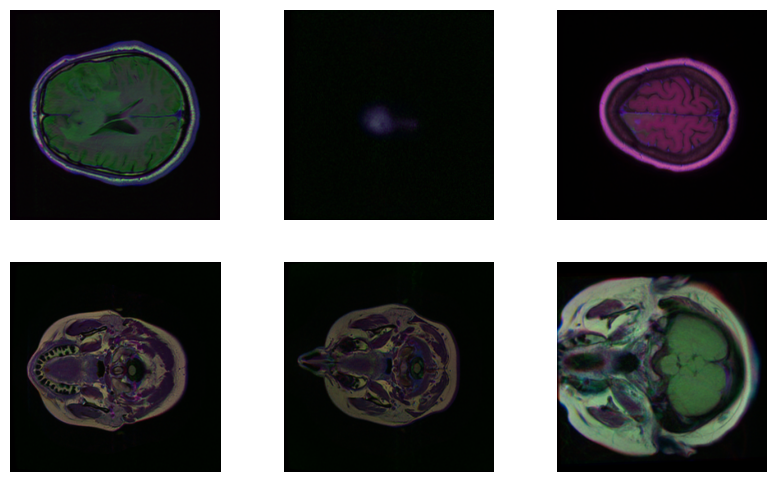

In [115]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(2):
    for j in range(3):
        example = val_dataset[random.randint(0, len(val_dataset))][0].numpy() * 255
        example = example.astype(np.uint8)
        example = example.T

        ax[i, j].imshow(example)
        ax[i, j].axis('off')

In [116]:
idx = 1
train_dataset[idx][1].min(), train_dataset[idx][1].max()

(tensor(0.), tensor(1.))

In [117]:
(2075 + 1107) / 3929 , (423 + 234) / 3929 , (58 + 32) / 3929

(0.8098752863324001, 0.16721812165945532, 0.022906592008144565)

In [118]:
example_image = np.array(Image.open(os.path.join(IMAGES_DIR, 'image_0.tif')).convert('RGB'))

example_image = train_transform_pipeline(example_image)

example_image.permute(1, 2, 0).shape

torch.Size([256, 256, 3])